In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.datasets import make_gaussian_quantiles

from sklearn.ensemble import AdaBoostClassifier


In [2]:
# Decision stump used as weak classifier
class Stump:
    
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None
        self.misclass = None
        self.misclass_rate = None
        self.weight_error = None   
        
    def fit(self, X, y, w=[]):
        
        n_samples, n_features = X.shape
        
        if len(w)==0:
            w = np.ones(n_samples)/n_samples
            
        min_error = float("inf")

        for feature_i in range(n_features):
            X_column = X[:, feature_i]
            thresholds = np.sort(np.unique(X_column))

            for i in range(len(thresholds)-1):
                
                threshold =  (thresholds[i] +  thresholds[i+1])/2
                
                # predict with polarity 1
                p = 1
                predictions = np.ones(n_samples)
                predictions[X_column < threshold] = -1

                # Error = sum of weights of misclassified samples
                error = sum(w[y!=predictions])

                if error > 0.5:
                    error = 1 - error
                    p = -1

                # store the best configuration
                if error < min_error:
                    self.polarity = p
                    self.threshold = threshold
                    self.feature_idx = feature_i
                    min_error = error
                    
        # calculate alpha
        self.misclass = self.predict(X)!=y
        self.misclass_rate = sum(self.misclass)/len(self.misclass)
        self.weight_error = sum(w[self.misclass])/sum(w)       
        self.alpha = 0.5 * np.log((1.0 - self.weight_error) / self.weight_error)
              
    def predict(self, X, m=None):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1

        return predictions

In [3]:
class Adaboost:
    def __init__(self, n_stumps=5, verbose=False):
        self.n_stumps = n_stumps
        self.stumps = []
        self.weights = None
        self.verbose = verbose

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.weights = w.copy()

        self.stumps = []

        # Iterate through classifiers
        for i in range(self.n_stumps):
            stump = Stump()

            # greedy search to find best threshold and feature
            stump.fit(X, y, w)
            
            if self.verbose:
                print("{:d}\t{:.2f}\t{:.2f}\t{:.2f}".format(i,stump.misclass_rate,stump.weight_error, stump.alpha))

            # update weights
            predictions = stump.predict(X)
            w *= np.exp(-stump.alpha * y * predictions)
            w /= np.sum(w)
            
            # Save stuff
            self.weights = np.vstack((self.weights, w))
            self.stumps.append(stump)

    def predict(self, X, m=None):
        return np.sign(self.predict_proba(X, m))
    
    def predict_proba(self, X, m=None):
        if m==None:
            m=len(self.stumps)
        stump_preds = [stump.alpha * stump.predict(X) for stump in self.stumps[:m]]
        return np.mean(stump_preds, axis=0)
            

## Plotter

In [4]:
def plot_db(model,X,y,p='predict',m=None):
    
    plot_step = 0.02
        
    plt.figure(figsize=(10, 5))

    # Plot the decision boundaries
    plt.figure(figsize=(7,7))
    x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
    y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    if model!=None:
        
        if isinstance(model,AdaBoostClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        else:
            if p=='predict':
                Z = model.predict(np.c_[xx.ravel(), yy.ravel()], m=m)
            else:
                Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()], m=m)

        Z = Z.reshape(xx.shape)

        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.bwr, alpha=0.5)
        plt.axis("tight")

            
    idx = np.where(y==-1)
    plt.scatter(X[idx, 0],X[idx, 1],c='b',s=20,edgecolor="k")
    
    idx = np.where(y==1)
    plt.scatter(X[idx, 0],X[idx, 1],c='r',s=20,edgecolor="k")
    
    if model!=None:
        misclassified = model.predict(X)!=y

        idx = np.logical_and(y==-1, misclassified)
        plt.scatter(X[idx, 0],X[idx, 1],c='b',s=20,edgecolor="w")

        idx = np.logical_and(y==1, misclassified)
        plt.scatter(X[idx, 0],X[idx, 1],c='r',s=20,edgecolor="w")
        
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks([])
    plt.yticks([])
    
    

## Plot alpha

/tmp/ipykernel_11779/3445327559.py:1: RuntimeWarning: divide by zero encountered in true_divide
  alpha = lambda x: 0.5 * np.log((1-x)/x)
/tmp/ipykernel_11779/3445327559.py:1: RuntimeWarning: divide by zero encountered in log
  alpha = lambda x: 0.5 * np.log((1-x)/x)


Text(0, 0.5, '$\\alpha(\\epsilon)$')

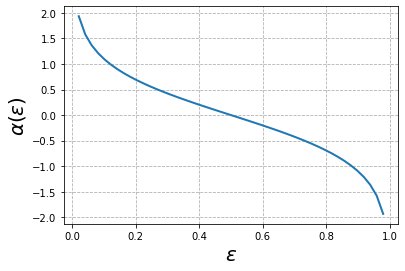

In [5]:
alpha = lambda x: 0.5 * np.log((1-x)/x)
e = np.linspace(0,1)
plt.figure
plt.plot(e,alpha(e),linewidth=2)
plt.grid(linestyle='--')
plt.xlabel('$\epsilon$',fontsize=20)
plt.ylabel('$\\alpha(\epsilon)$',fontsize=20)


# Load data

<Figure size 720x360 with 0 Axes>

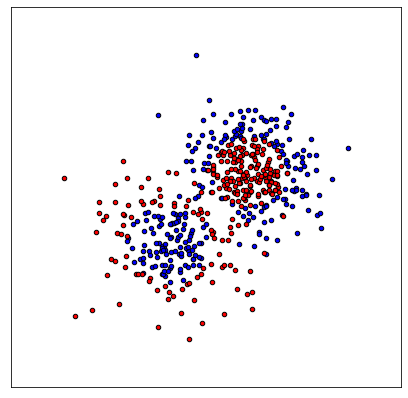

In [6]:
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1 )
y1[y1==0] = -1
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1 )
y2[y2==0]=-1
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2))

plot_db(None, X, y)

## Single stump

(0.378, 0.378)

<Figure size 720x360 with 0 Axes>

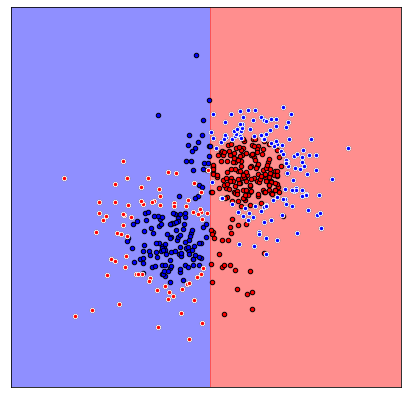

In [7]:
stump = Stump()
stump.fit(X,y)
plot_db(stump, X, y)
stump.weight_error, stump.misclass_rate

## Small Adaboost

0	0.38	0.38	0.25
1	0.40	0.39	0.22
2	0.45	0.35	0.32
3	0.41	0.35	0.30
4	0.45	0.37	0.27
5	0.38	0.34	0.32
6	0.40	0.38	0.24
7	0.45	0.37	0.27
8	0.41	0.38	0.24


<Figure size 720x360 with 0 Axes>

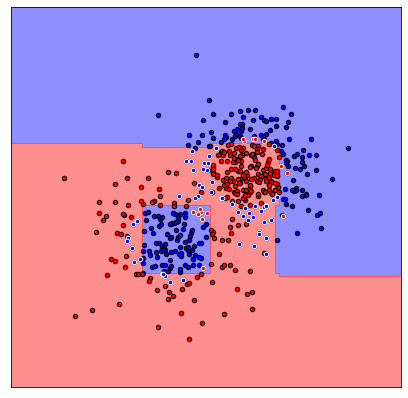

In [8]:
adaboost = Adaboost(n_stumps=9, verbose=True)
adaboost.fit(X, y)
plot_db(adaboost, X, y)

## Medium Adaboost

/tmp/ipykernel_11779/4092315767.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 5))


<Figure size 720x360 with 0 Axes>

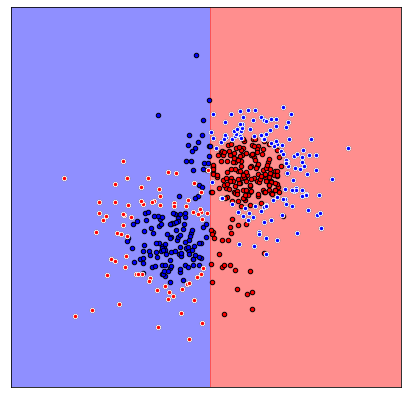

<Figure size 720x360 with 0 Axes>

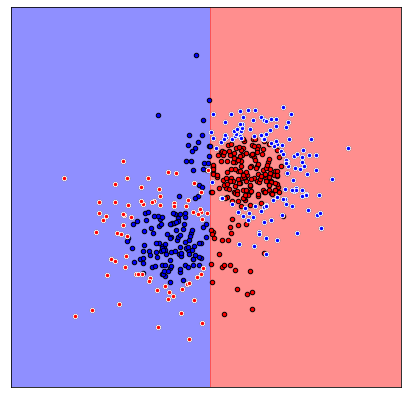

<Figure size 720x360 with 0 Axes>

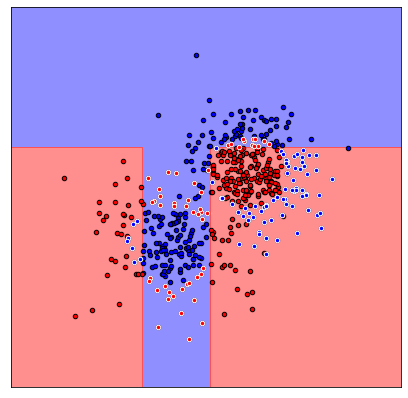

<Figure size 720x360 with 0 Axes>

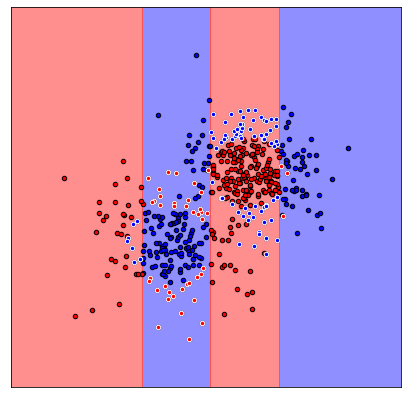

<Figure size 720x360 with 0 Axes>

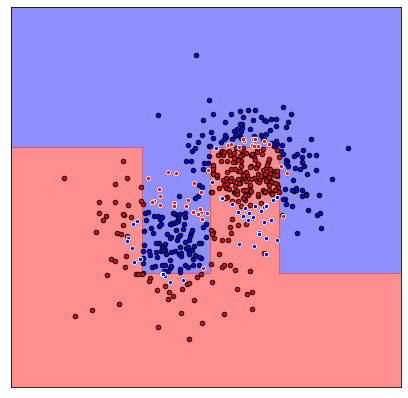

<Figure size 720x360 with 0 Axes>

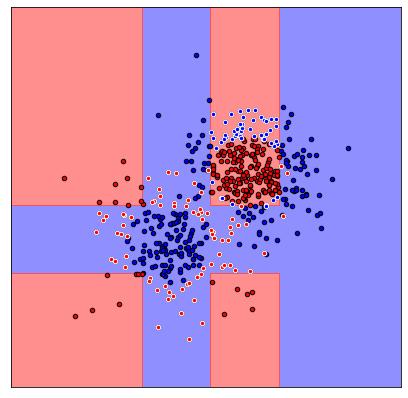

<Figure size 720x360 with 0 Axes>

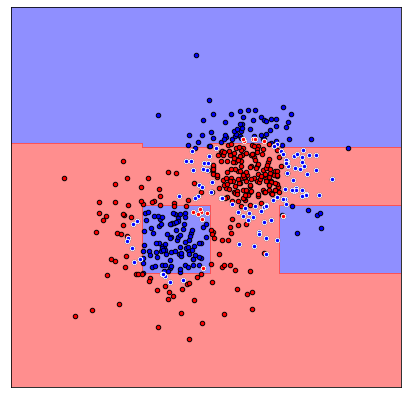

<Figure size 720x360 with 0 Axes>

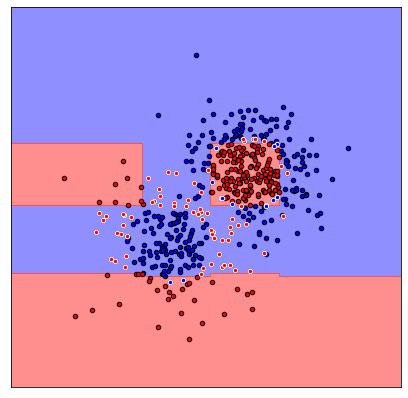

<Figure size 720x360 with 0 Axes>

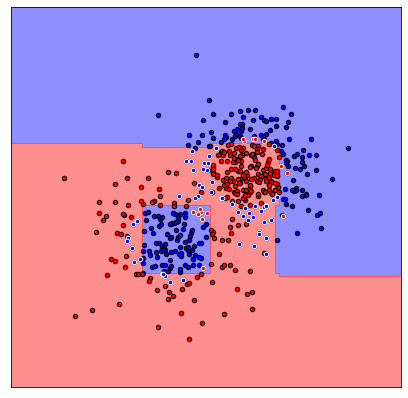

<Figure size 720x360 with 0 Axes>

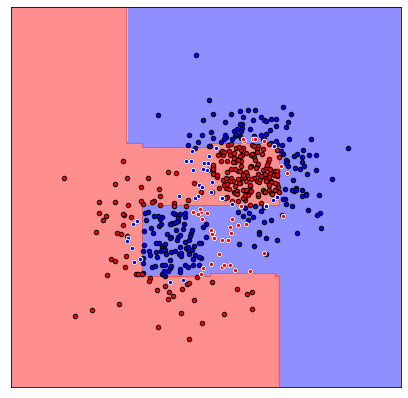

<Figure size 720x360 with 0 Axes>

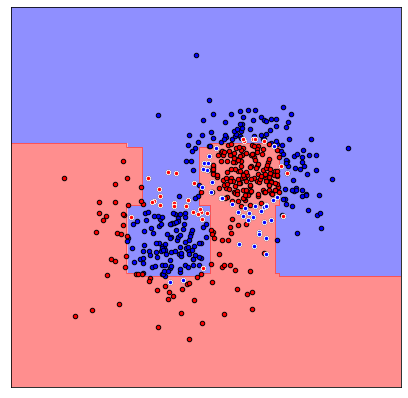

<Figure size 720x360 with 0 Axes>

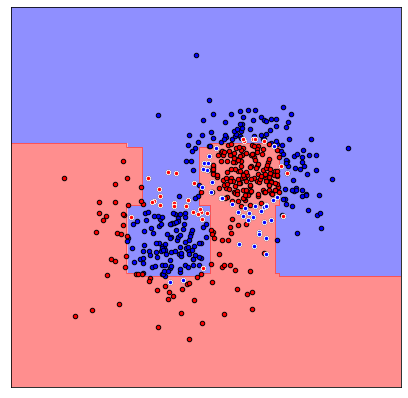

<Figure size 720x360 with 0 Axes>

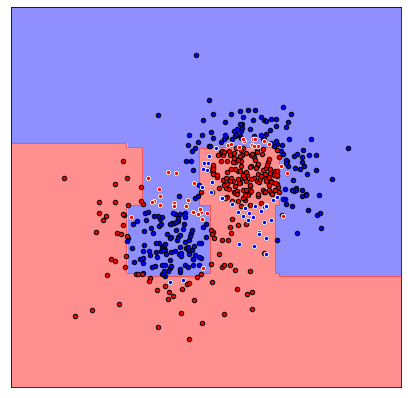

<Figure size 720x360 with 0 Axes>

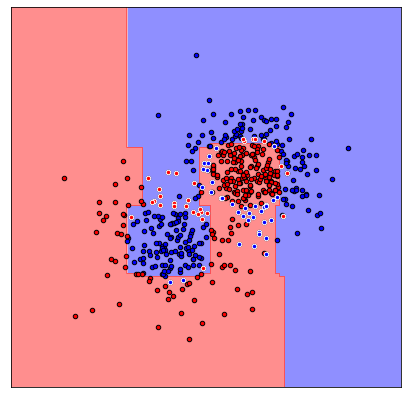

<Figure size 720x360 with 0 Axes>

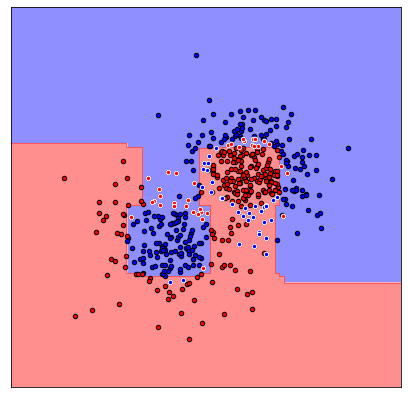

<Figure size 720x360 with 0 Axes>

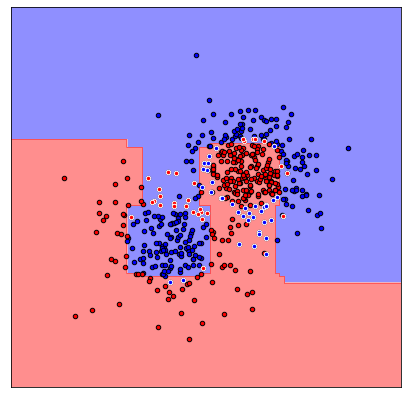

<Figure size 720x360 with 0 Axes>

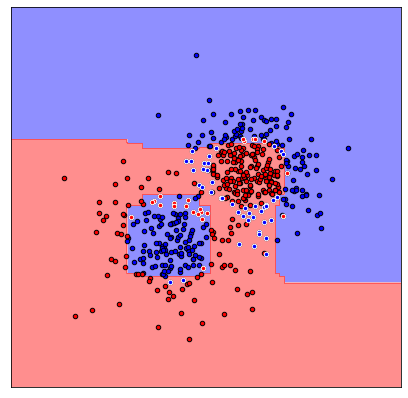

<Figure size 720x360 with 0 Axes>

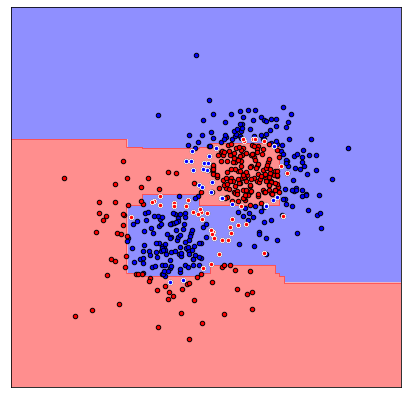

<Figure size 720x360 with 0 Axes>

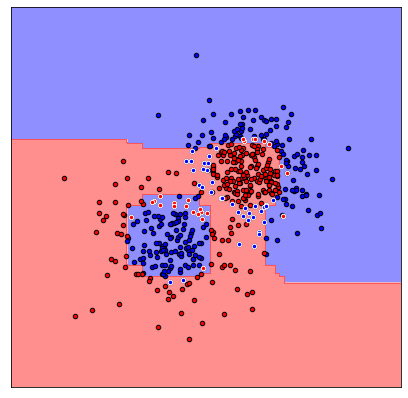

In [9]:
for i in range(1,20):
    adaboost = Adaboost(n_stumps=i)
    adaboost.fit(X, y)
    plot_db(adaboost, X, y)
    plt.savefig("stump{}".format(i), transparent=True)

## Large Adaboost

In [10]:
adaboost = Adaboost(n_stumps=150)
adaboost.fit(X, y)

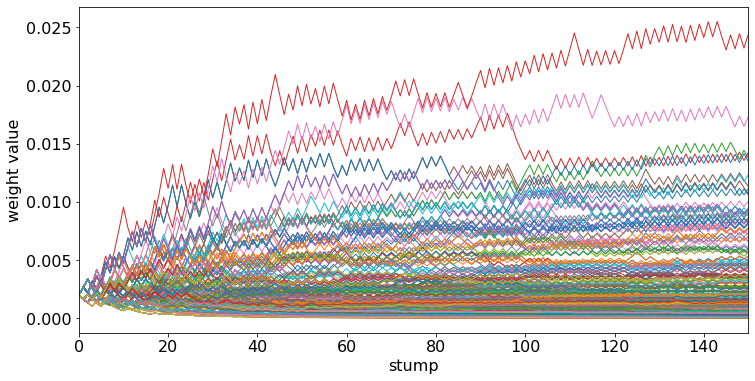

In [11]:
plt.figure(figsize=(12,6))
plt.plot(range(adaboost.n_stumps+1),adaboost.weights,linewidth=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0,adaboost.n_stumps)
# plt.grid()
plt.ylabel('weight value',fontsize=16)
plt.xlabel('stump',fontsize=16)
plt.show()

Text(0.5, 0, 'stump')

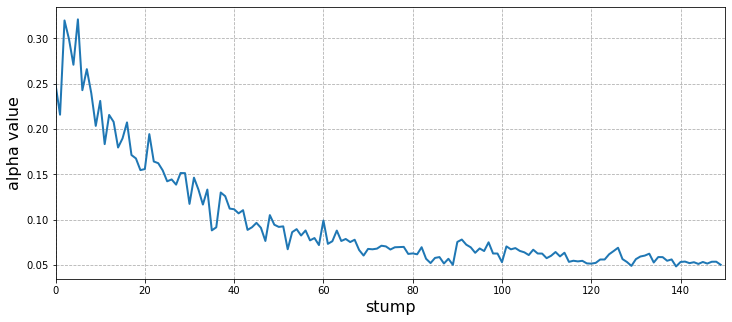

In [12]:
alphas = [stump.alpha for stump in adaboost.stumps]
plt.figure(figsize=(12,5))
plt.plot(range(150),alphas,linewidth=2)
plt.xlim(0,150)
plt.grid(linestyle='--')
plt.ylabel('alpha value',fontsize=16)
plt.xlabel('stump',fontsize=16)

In [13]:
alphas

[0.2490229485597959,
 0.215849819778075,
 0.3198732458509676,
 0.2994228770654438,
 0.2710034082078879,
 0.3211022049787165,
 0.24291768771712638,
 0.2661325911390657,
 0.2395548997122634,
 0.20345605450905482,
 0.23104235031911602,
 0.18336567355621142,
 0.21557513038245235,
 0.20795945584745495,
 0.1796176440505545,
 0.18967885191418032,
 0.20734610136348974,
 0.17134592297898804,
 0.16756064656718733,
 0.15465501481790767,
 0.15582956255645966,
 0.19443038704804508,
 0.1641961515301386,
 0.16230854201504646,
 0.15437075048791232,
 0.14232083442509183,
 0.14438379635893178,
 0.13863534870385644,
 0.15145079949559676,
 0.15132332646154295,
 0.11733292879474541,
 0.14632467883177175,
 0.1332387132713914,
 0.11664115205248254,
 0.1332058187248402,
 0.0881272271566179,
 0.09153252445169296,
 0.12995149174352333,
 0.12589560256644447,
 0.11217842248424362,
 0.11145258404144691,
 0.10691648693711629,
 0.11043670012072317,
 0.08865169964947942,
 0.0915816337729675,
 0.0964360341216585,
 0.0

<Figure size 720x360 with 0 Axes>

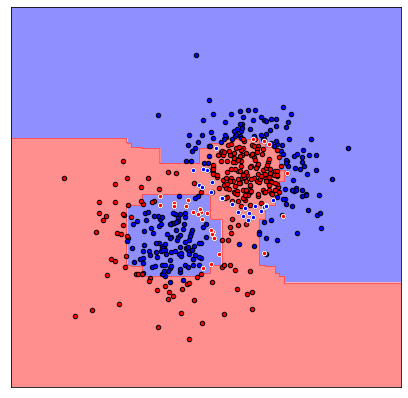

<Figure size 720x360 with 0 Axes>

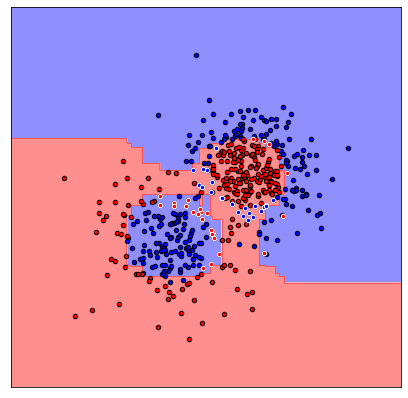

<Figure size 720x360 with 0 Axes>

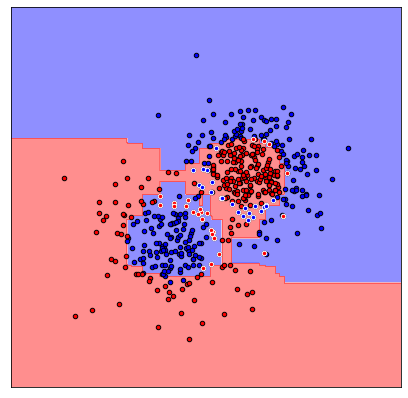

<Figure size 720x360 with 0 Axes>

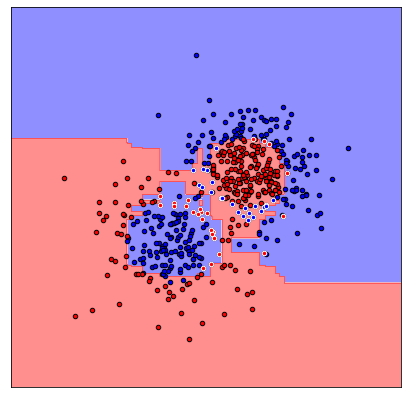

<Figure size 720x360 with 0 Axes>

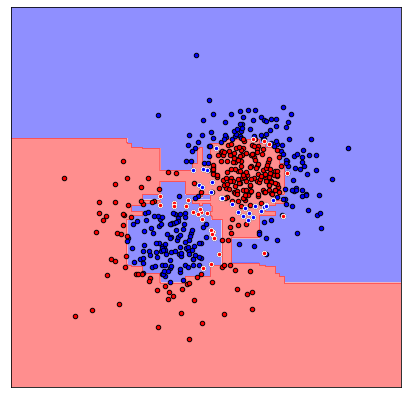

<Figure size 720x360 with 0 Axes>

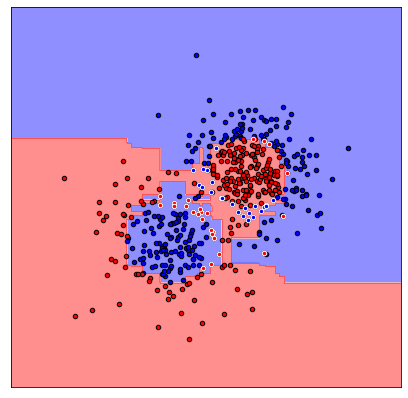

In [14]:
for m in [40,60,80,100,120,140]:
    plot_db(adaboost,X,y,m=m)
    plt.savefig("adaboost{}".format(m), transparent=True)

## scikitlearn adaboost

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
model.fit(X, y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))

<Figure size 720x360 with 0 Axes>

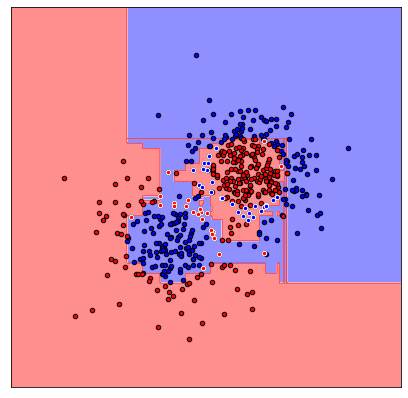

In [16]:
plot_db(model,X,y)